# Synthetic Dataset & Scalability
C. Heiser, 2019

---
__The purpose of this notebook is to evaluate our structural preservation metrics on a synthetic dataset of known high-dimensional structure and determine their scalability to datasets with a large number of observations.__  

As a reminder, unique pairwise distances in a dataset with _n_ cells is calculated as:  
$$D=(n*(n-1))/2$$  
  
To benchmark these techniques, we are using a **"Swiss Roll"** dataset built using `sklearn.datasets.make_swiss_roll()`.

In [1]:
import sys
sys.path.append('../')
from fcc_utils import *

In [2]:
from sklearn import datasets # for swiss roll dataset
import mpl_toolkits.mplot3d.axes3d as p3 # 3D plotting

In [3]:
# create dictionary for dumping results into
final_distance_stats = {1000:{'R':{}, 'EMD':{}, 'Knn Pres.':{}, 'Time':{}}, 
                        10000:{'R':{}, 'EMD':{}, 'Knn Pres.':{}, 'Time':{}}, 
                        50000:{'R':{}, 'EMD':{}, 'Knn Pres.':{}, 'Time':{}}, 
                        100000:{'R':{}, 'EMD':{}, 'Knn Pres.':{}, 'Time':{}}
                       }

---
### 1K-Point Swiss Roll

In [4]:
X, t = datasets.make_swiss_roll(n_samples=1000, noise=0.0, random_state=18)

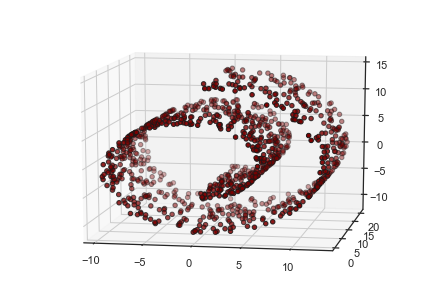

In [5]:
fig = plt.figure()
ax = p3.Axes3D(fig)
ax.view_init(12, -80)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], color=plt.cm.jet(t), s=20, edgecolor='k')

In [6]:
swiss_1k = sc.AnnData(X=X) # initialize AnnData
swiss_1k.obs['pos'] = t # add univariate position according to main dim of manifold to .obs

swiss_1k

AnnData object with n_obs × n_vars = 1000 × 3 
    obs: 'pos'

In [7]:
# perform PCA
%time sc.tl.pca(swiss_1k, n_comps=2)

CPU times: user 15.3 ms, sys: 5.29 ms, total: 20.6 ms
Wall time: 5.51 ms


In [8]:
# create neighborhood graphs from PCA results for UMAP and Louvain clustering
# heads-up: you will get a numba deprecation warning the first time you run this
%time sc.pp.neighbors(swiss_1k, n_neighbors=30, use_rep='X', knn=True, random_state=18, metric='euclidean', copy=False)

/Users/cody/.virtualenvs/lau_lab/lib/python3.7/site-packages/umap/umap_.py:349: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "fuzzy_simplicial_set" failed type inference due to: Untyped global name 'nearest_neighbors': cannot determine Numba type of <class 'function'>

File "../../../.virtualenvs/lau_lab/lib/python3.7/site-packages/umap/umap_.py", line 467:
def fuzzy_simplicial_set(
    <source elided>
    if knn_indices is None or knn_dists is None:
        knn_indices, knn_dists, _ = nearest_neighbors(
        ^

  @numba.jit()
/Users/cody/.virtualenvs/lau_lab/lib/python3.7/site-packages/numba/compiler.py:742: NumbaWarning: Function "fuzzy_simplicial_set" was compiled in object mode without forceobj=True.

File "../../../.virtualenvs/lau_lab/lib/python3.7/site-packages/umap/umap_.py", line 350:
@numba.jit()
def fuzzy_simplicial_set(
^

  self.func_ir.loc))
/Users/cody/.virtualenvs/lau_lab/lib/python3.7/site-packages/numba/compile

CPU times: user 2.83 s, sys: 118 ms, total: 2.94 s
Wall time: 2.57 s


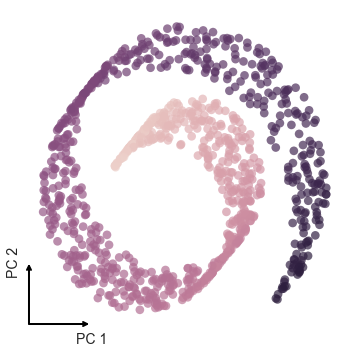

In [9]:
DR_plot(dim_name='PC').plot(swiss_1k.obsm['X_pca'], color=swiss_1k.obs['pos'])

In [10]:
# perform UMAP
%time sc.tl.umap(swiss_1k, random_state=18)

CPU times: user 2.91 s, sys: 87.2 ms, total: 3 s
Wall time: 2.51 s


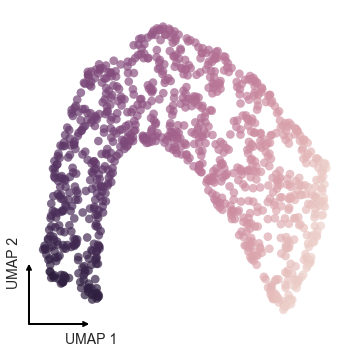

In [11]:
DR_plot(dim_name='UMAP').plot(swiss_1k.obsm['X_umap'], color=swiss_1k.obs['pos'])

In [12]:
# perform t-SNE
%time sc.tl.tsne(swiss_1k, use_rep='X', perplexity=30, random_state=18)

CPU times: user 3.86 s, sys: 3.66 ms, total: 3.86 s
Wall time: 3.87 s


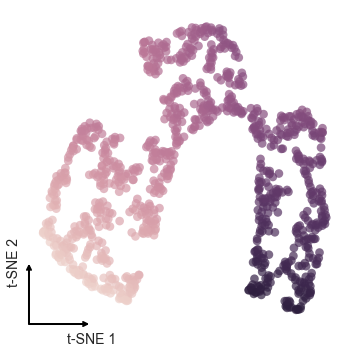

In [13]:
DR_plot(dim_name='t-SNE').plot(swiss_1k.obsm['X_tsne'], color=swiss_1k.obs['pos'])

In [14]:
%%time
# save distance matrices in AnnData object for easy access
swiss_1k.uns['tsne_distance'] = pdist(swiss_1k.obsm['X_tsne'])
swiss_1k.uns['umap_distance'] = pdist(swiss_1k.obsm['X_umap'])
swiss_1k.uns['pca_distance'] = pdist(swiss_1k.obsm['X_pca'])
swiss_1k.uns['native_distance'] = pdist(swiss_1k.X)

CPU times: user 6.14 ms, sys: 2.13 ms, total: 8.27 ms
Wall time: 8.04 ms


R: 0.8567
EMD: 0.0386
CPU times: user 993 ms, sys: 122 ms, total: 1.11 s
Wall time: 488 ms


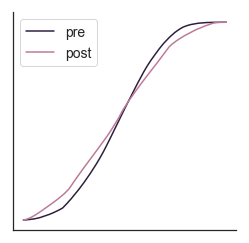

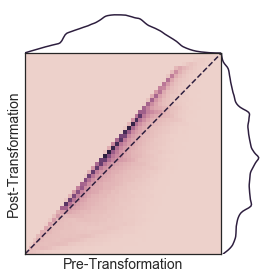

In [15]:
%%time
pre_flat_norm, post_flat_norm, mantel_stats, EMD = distance_stats(pre=swiss_1k.uns['native_distance'], post=swiss_1k.uns['pca_distance'])
print('R: {}\nEMD: {}'.format(round(mantel_stats[0],4), round(EMD,4)))
plt.figure(figsize=(4,4))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
# dump o/p into dictionary
final_distance_stats[1000]['R']['PCA (2)'], final_distance_stats[1000]['EMD']['PCA (2)'] = mantel_stats[0], EMD

R: 0.38
EMD: 0.0499
CPU times: user 989 ms, sys: 109 ms, total: 1.1 s
Wall time: 465 ms


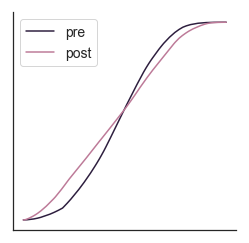

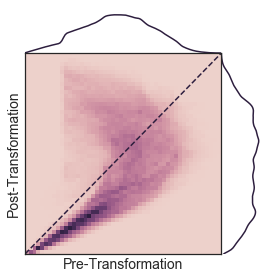

In [16]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD = distance_stats(pre=swiss_1k.uns['native_distance'], post=swiss_1k.uns['tsne_distance'])
print('R: {}\nEMD: {}'.format(round(mantel_stats[0],4), round(EMD,4)))
plt.figure(figsize=(4,4))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
# dump o/p into dictionary
final_distance_stats[1000]['R']['t-SNE'], final_distance_stats[1000]['EMD']['t-SNE'] = mantel_stats[0], EMD

R: 0.2716
EMD: 0.0772
CPU times: user 984 ms, sys: 112 ms, total: 1.1 s
Wall time: 464 ms


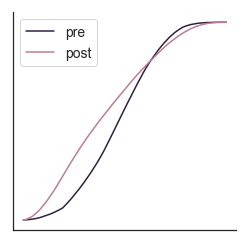

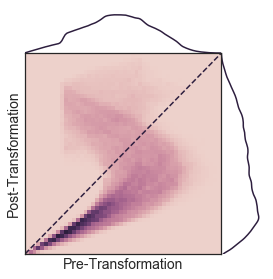

In [17]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD = distance_stats(pre=swiss_1k.uns['native_distance'], post=swiss_1k.uns['umap_distance'])
print('R: {}\nEMD: {}'.format(round(mantel_stats[0],4), round(EMD,4)))
plt.figure(figsize=(4,4))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
# dump o/p into dictionary
final_distance_stats[1000]['R']['UMAP'], final_distance_stats[1000]['EMD']['UMAP'] = mantel_stats[0], EMD

---
### 10K-Point Swiss Roll

In [18]:
X, t = datasets.make_swiss_roll(n_samples=10000, noise=0.0, random_state=18)

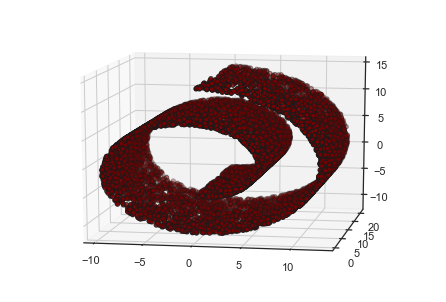

In [19]:
fig = plt.figure()
ax = p3.Axes3D(fig)
ax.view_init(12, -80)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], color=plt.cm.jet(t), s=20, edgecolor='k')

In [20]:
swiss_10k = sc.AnnData(X=X) # initialize AnnData
swiss_10k.obs['pos'] = t # add univariate position according to main dim of manifold to .obs

swiss_10k

AnnData object with n_obs × n_vars = 10000 × 3 
    obs: 'pos'

In [21]:
# perform PCA
%time sc.tl.pca(swiss_10k, n_comps=2)

CPU times: user 12.3 ms, sys: 20.3 ms, total: 32.6 ms
Wall time: 4.69 ms


In [22]:
# create neighborhood graphs from PCA results for UMAP and Louvain clustering
# heads-up: you will get a numba deprecation warning the first time you run this
sc.pp.neighbors(swiss_10k, n_neighbors=100, use_rep='X', knn=True, random_state=18, metric='euclidean', copy=False)

/Users/cody/.virtualenvs/lau_lab/lib/python3.7/site-packages/umap/rp_tree.py:450: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "make_euclidean_tree" failed type inference due to: Cannot unify RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none) and RandomProjectionTreeNode(none, bool, array(float32, 1d, C), float64, RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none), RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none)) for '$14.16', defined at /Users/cody/.virtualenvs/lau_lab/lib/python3.7/site-packages/umap/rp_tree.py (457)

File "../../../.virtualenvs/lau_lab/lib/python3.7/site-packages/umap/rp_tree.py", line 457:
def make_euclidean_tree(data, indices, rng_state, leaf_size=30):
    <source elided>

        left_node = make_euclidean_tree(data, left_indices, rng_state, leaf_size)
        ^

[1] During: resolving callee type: recursive(type(CPUDispatcher(<funct

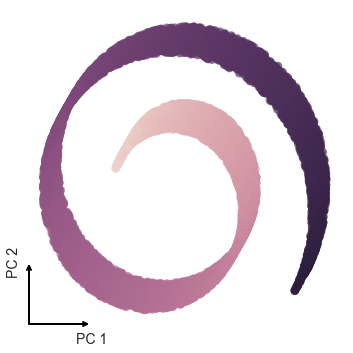

In [23]:
DR_plot(dim_name='PC').plot(swiss_10k.obsm['X_pca'], color=swiss_10k.obs['pos'])

In [24]:
# perform UMAP
%time sc.tl.umap(swiss_10k, random_state=18)

CPU times: user 21.4 s, sys: 419 ms, total: 21.8 s
Wall time: 19 s


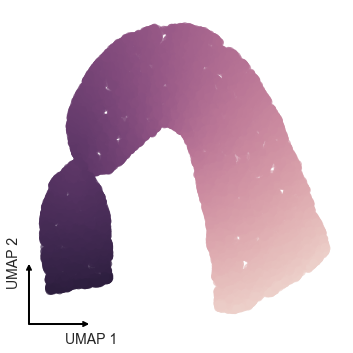

In [25]:
DR_plot(dim_name='UMAP').plot(swiss_10k.obsm['X_umap'], color=swiss_10k.obs['pos'])

In [26]:
# perform t-SNE
%time sc.tl.tsne(swiss_10k, use_rep='X', perplexity=100, random_state=18)

CPU times: user 1min 9s, sys: 823 ms, total: 1min 10s
Wall time: 1min 10s


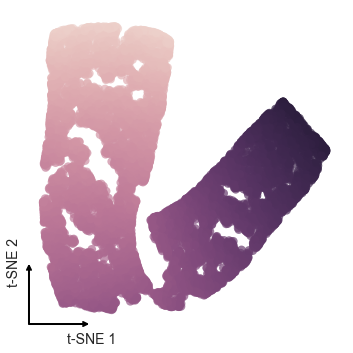

In [27]:
DR_plot(dim_name='t-SNE').plot(swiss_10k.obsm['X_tsne'], color=swiss_10k.obs['pos'])

In [28]:
%%time
# save distance matrices in AnnData object for easy access
swiss_10k.uns['tsne_distance'] = pdist(swiss_10k.obsm['X_tsne'])
swiss_10k.uns['umap_distance'] = pdist(swiss_10k.obsm['X_umap'])
swiss_10k.uns['pca_distance'] = pdist(swiss_10k.obsm['X_pca'])
swiss_10k.uns['native_distance'] = pdist(swiss_10k.X)

CPU times: user 577 ms, sys: 255 ms, total: 832 ms
Wall time: 831 ms


R: 0.8512
EMD: 0.051
CPU times: user 52.4 s, sys: 4.36 s, total: 56.7 s
Wall time: 56.1 s


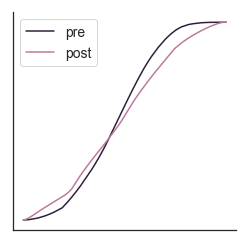

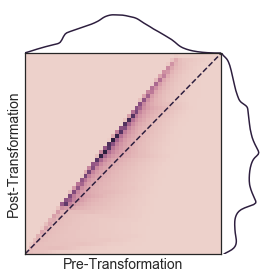

In [29]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD = distance_stats(pre=swiss_10k.uns['native_distance'], post=swiss_10k.uns['pca_distance'])
print('R: {}\nEMD: {}'.format(round(mantel_stats[0],4), round(EMD,4)))
plt.figure(figsize=(4,4))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
# dump o/p into dictionary
final_distance_stats[10000]['R']['PCA (2)'], final_distance_stats[10000]['EMD']['PCA (2)'] = mantel_stats[0], EMD

R: 0.4178
EMD: 0.0448
CPU times: user 51.8 s, sys: 3.13 s, total: 55 s
Wall time: 54.1 s


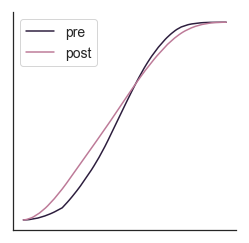

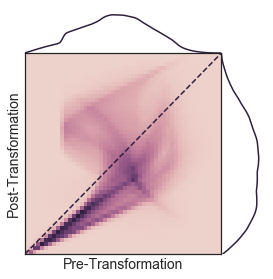

In [30]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD = distance_stats(pre=swiss_10k.uns['native_distance'], post=swiss_10k.uns['tsne_distance'])
print('R: {}\nEMD: {}'.format(round(mantel_stats[0],4), round(EMD,4)))
plt.figure(figsize=(4,4))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
# dump o/p into dictionary
final_distance_stats[10000]['R']['t-SNE'], final_distance_stats[10000]['EMD']['t-SNE'] = mantel_stats[0], EMD

R: 0.3486
EMD: 0.0528
CPU times: user 51 s, sys: 2.19 s, total: 53.2 s
Wall time: 52.3 s


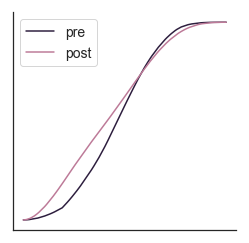

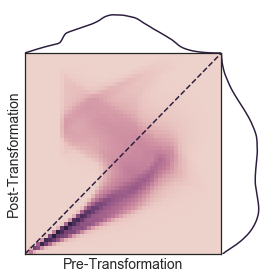

In [31]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD = distance_stats(pre=swiss_10k.uns['native_distance'], post=swiss_10k.uns['umap_distance'])
print('R: {}\nEMD: {}'.format(round(mantel_stats[0],4), round(EMD,4)))
plt.figure(figsize=(4,4))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
# dump o/p into dictionary
final_distance_stats[10000]['R']['UMAP'], final_distance_stats[10000]['EMD']['UMAP'] = mantel_stats[0], EMD

---
### 50K-Point Swiss Roll

In [32]:
X, t = datasets.make_swiss_roll(n_samples=50000, noise=0.0, random_state=18)

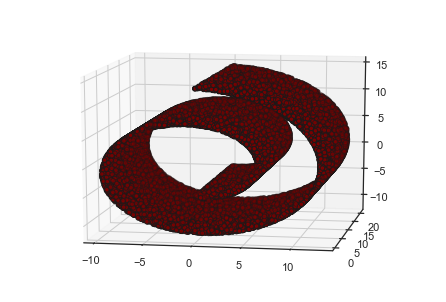

In [33]:
fig = plt.figure()
ax = p3.Axes3D(fig)
ax.view_init(12, -80)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], color=plt.cm.jet(t), s=20, edgecolor='k')

In [34]:
swiss_50k = sc.AnnData(X=X) # initialize AnnData
swiss_50k.obs['pos'] = t # add univariate position according to main dim of manifold to .obs

swiss_50k

AnnData object with n_obs × n_vars = 50000 × 3 
    obs: 'pos'

In [35]:
# perform PCA
%time sc.tl.pca(swiss_50k, n_comps=2)

CPU times: user 32.3 ms, sys: 44.2 ms, total: 76.6 ms
Wall time: 10.2 ms


In [36]:
# create neighborhood graphs from PCA results for UMAP and Louvain clustering
# heads-up: you will get a numba deprecation warning the first time you run this
%time sc.pp.neighbors(swiss_50k, n_neighbors=225, use_rep='X', knn=True, random_state=18, metric='euclidean', copy=False)

/Users/cody/.virtualenvs/lau_lab/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../.virtualenvs/lau_lab/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))


CPU times: user 1min, sys: 1.2 s, total: 1min 1s
Wall time: 1min


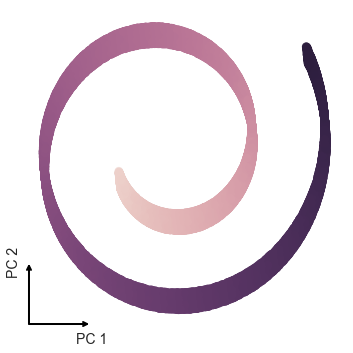

In [37]:
DR_plot(dim_name='PC').plot(swiss_50k.obsm['X_pca'], color=swiss_50k.obs['pos'])

In [38]:
# perform UMAP
%time sc.tl.umap(swiss_50k, random_state=18)

CPU times: user 1min 43s, sys: 4.03 s, total: 1min 47s
Wall time: 1min 1s


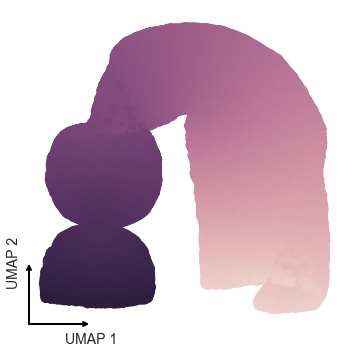

In [39]:
DR_plot(dim_name='UMAP').plot(swiss_50k.obsm['X_umap'], color=swiss_50k.obs['pos'])

In [40]:
# perform t-SNE
%time sc.tl.tsne(swiss_50k, use_rep='X', perplexity=225, random_state=18)

CPU times: user 11min 6s, sys: 7.55 s, total: 11min 13s
Wall time: 11min 14s


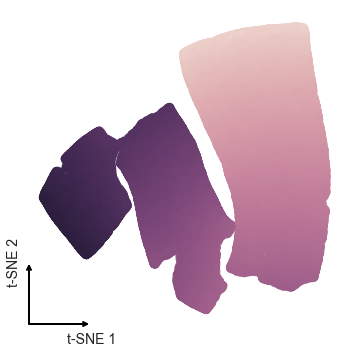

In [41]:
DR_plot(dim_name='t-SNE').plot(swiss_50k.obsm['X_tsne'], color=swiss_50k.obs['pos'])

In [42]:
%%time
# save distance matrices in AnnData object for easy access
swiss_50k.uns['tsne_distance'] = pdist(swiss_50k.obsm['X_tsne'])
swiss_50k.uns['umap_distance'] = pdist(swiss_50k.obsm['X_umap'])
swiss_50k.uns['pca_distance'] = pdist(swiss_50k.obsm['X_pca'])
swiss_50k.uns['native_distance'] = pdist(swiss_50k.X)

CPU times: user 15.1 s, sys: 7.19 s, total: 22.3 s
Wall time: 22.5 s


R: 0.8512
EMD: 0.049
CPU times: user 2min 34s, sys: 35.2 s, total: 3min 9s
Wall time: 3min 27s


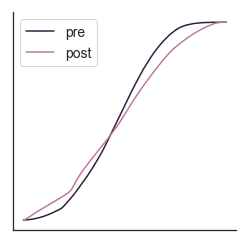

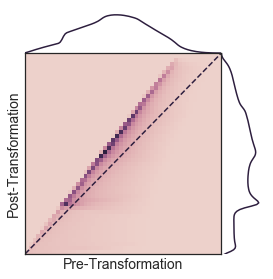

In [43]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD = distance_stats(pre=swiss_50k.uns['native_distance'], post=swiss_50k.uns['pca_distance'], downsample=49995000)
print('R: {}\nEMD: {}'.format(round(mantel_stats[0],4), round(EMD,4)))
plt.figure(figsize=(4,4))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
# dump o/p into dictionary
final_distance_stats[50000]['R']['PCA (2)'], final_distance_stats[50000]['EMD']['PCA (2)'] = mantel_stats[0], EMD

R: 0.3969
EMD: 0.0657
CPU times: user 2min 49s, sys: 40.1 s, total: 3min 30s
Wall time: 3min 40s


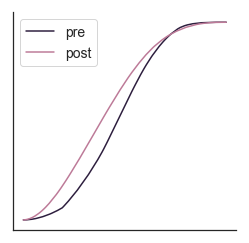

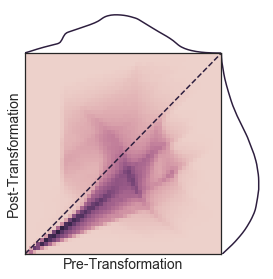

In [44]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD = distance_stats(pre=swiss_50k.uns['native_distance'], post=swiss_50k.uns['tsne_distance'], downsample=49995000)
print('R: {}\nEMD: {}'.format(round(mantel_stats[0],4), round(EMD,4)))
plt.figure(figsize=(4,4))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
# dump o/p into dictionary
final_distance_stats[50000]['R']['t-SNE'], final_distance_stats[50000]['EMD']['t-SNE'] = mantel_stats[0], EMD

R: 0.4272
EMD: 0.0465
CPU times: user 2min 31s, sys: 27.6 s, total: 2min 58s
Wall time: 3min 21s


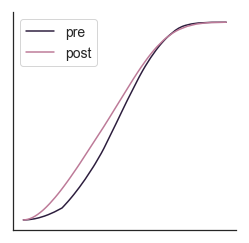

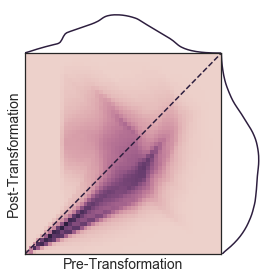

In [45]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD = distance_stats(pre=swiss_50k.uns['native_distance'], post=swiss_50k.uns['umap_distance'], downsample=49995000)
print('R: {}\nEMD: {}'.format(round(mantel_stats[0],4), round(EMD,4)))
plt.figure(figsize=(4,4))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
# dump o/p into dictionary
final_distance_stats[50000]['R']['UMAP'], final_distance_stats[50000]['EMD']['UMAP'] = mantel_stats[0], EMD

---
### 100K-Point Swiss Roll

In [46]:
X, t = datasets.make_swiss_roll(n_samples=100000, noise=0.0, random_state=18)

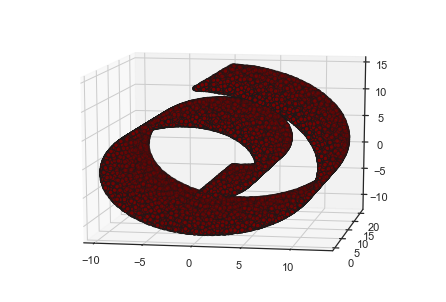

In [47]:
fig = plt.figure()
ax = p3.Axes3D(fig)
ax.view_init(12, -80)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], color=plt.cm.jet(t), s=20, edgecolor='k')

In [48]:
swiss_100k = sc.AnnData(X=X) # initialize AnnData
swiss_100k.obs['pos'] = t # add univariate position according to main dim of manifold to .obs

swiss_100k

AnnData object with n_obs × n_vars = 100000 × 3 
    obs: 'pos'

In [49]:
# perform PCA
%time sc.tl.pca(swiss_100k, n_comps=2)

CPU times: user 101 ms, sys: 98.3 ms, total: 199 ms
Wall time: 24.7 ms


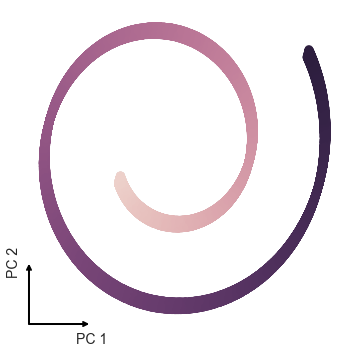

In [50]:
DR_plot(dim_name='PC').plot(swiss_100k.obsm['X_pca'], color=swiss_100k.obs['pos'])

In [51]:
# create neighborhood graphs from PCA results for UMAP and Louvain clustering
# heads-up: you will get a numba deprecation warning the first time you run this
sc.pp.neighbors(swiss_100k, n_neighbors=300, use_rep='X', knn=True, random_state=18, metric='euclidean', copy=False)

/Users/cody/.virtualenvs/lau_lab/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../.virtualenvs/lau_lab/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))


In [52]:
# perform UMAP
%time sc.tl.umap(swiss_100k, random_state=18)

CPU times: user 5min 32s, sys: 18 s, total: 5min 50s
Wall time: 2min 37s


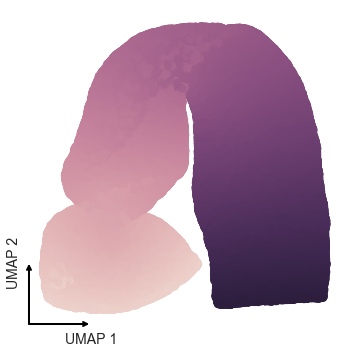

In [53]:
DR_plot(dim_name='UMAP').plot(swiss_100k.obsm['X_umap'], color=swiss_100k.obs['pos'])

In [54]:
# perform t-SNE
%time sc.tl.tsne(swiss_100k, use_rep='X', perplexity=300, random_state=18)

CPU times: user 32min 5s, sys: 23.4 s, total: 32min 28s
Wall time: 33min 8s


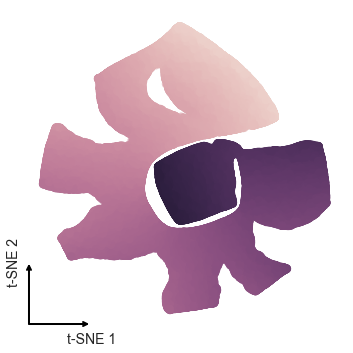

In [ ]:
DR_plot(dim_name='t-SNE').plot(swiss_100k.obsm['X_tsne'], color=swiss_100k.obs['pos'])

In [ ]:
%%time
# save distance matrices in AnnData object for easy access
swiss_100k.uns['tsne_distance'] = pdist(swiss_100k.obsm['X_tsne'])
swiss_100k.uns['umap_distance'] = pdist(swiss_100k.obsm['X_umap'])
swiss_100k.uns['pca_distance'] = pdist(swiss_100k.obsm['X_pca'])
swiss_100k.uns['native_distance'] = pdist(swiss_100k.X)

In [ ]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD = distance_stats(pre=swiss_100k.uns['native_distance'], post=swiss_100k.uns['pca_distance'], downsample=49995000)
print('R: {}\nEMD: {}'.format(round(mantel_stats[0],4), round(EMD,4)))
plt.figure(figsize=(4,4))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
# dump o/p into dictionary
final_distance_stats[100000]['R']['PCA (2)'], final_distance_stats[100000]['EMD']['PCA (2)'] = mantel_stats[0], EMD

In [ ]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD = distance_stats(pre=swiss_100k.uns['native_distance'], post=swiss_100k.uns['tsne_distance'], downsample=49995000)
print('R: {}\nEMD: {}'.format(round(mantel_stats[0],4), round(EMD,4)))
plt.figure(figsize=(4,4))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
# dump o/p into dictionary
final_distance_stats[100000]['R']['t-SNE'], final_distance_stats[100000]['EMD']['t-SNE'] = mantel_stats[0], EMD

In [ ]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD = distance_stats(pre=swiss_100k.uns['native_distance'], post=swiss_100k.uns['umap_distance'], downsample=49995000)
print('R: {}\nEMD: {}'.format(round(mantel_stats[0],4), round(EMD,4)))
plt.figure(figsize=(4,4))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
# dump o/p into dictionary
final_distance_stats[100000]['R']['UMAP'], final_distance_stats[100000]['EMD']['UMAP'] = mantel_stats[0], EMD

---
### Knn Preservation

In [ ]:
%%time
knn_graph(distance_matrix(swiss_1k.X, swiss_1k.X), k=30, swiss_1k, save_rep='native_knn')
knn_graph(distance_matrix(swiss_1k.obsm['X_pca'], swiss_1k.obsm['X_pca']), k=30, swiss_1k, save_rep='pca_knn')
knn_graph(distance_matrix(swiss_1k.obsm['X_tsne'], swiss_1k.obsm['X_tsne']), k=30, swiss_1k, save_rep='tsne_knn')
knn_graph(distance_matrix(swiss_1k.obsm['X_umap'], swiss_1k.obsm['X_umap']), k=30, swiss_1k, save_rep='umap_knn')

In [ ]:
final_distance_stats[1000]['Knn Pres.']['PCA (2)'] = knn_preservation(pre=swiss_1k.uns['native_knn'], post=swiss_1k.uns['pca_knn'])
final_distance_stats[1000]['Knn Pres.']['t-SNE'] = knn_preservation(pre=swiss_1k.uns['native_knn'], post=swiss_1k.uns['tsne_knn'])
final_distance_stats[1000]['Knn Pres.']['UMAP'] = knn_preservation(pre=swiss_1k.uns['native_knn'], post=swiss_1k.uns['umap_knn'])

In [ ]:
%%time
knn_graph(distance_matrix(swiss_10k.X, swiss_10k.X), k=100, swiss_10k, save_rep='native_knn')
knn_graph(distance_matrix(swiss_10k.obsm['X_pca'], swiss_10k.obsm['X_pca']), k=100, swiss_10k, save_rep='pca_knn')
knn_graph(distance_matrix(swiss_10k.obsm['X_tsne'], swiss_10k.obsm['X_tsne']), k=100, swiss_10k, save_rep='tsne_knn')
knn_graph(distance_matrix(swiss_10k.obsm['X_umap'], swiss_10k.obsm['X_umap']), k=100, swiss_10k, save_rep='umap_knn')

In [ ]:
final_distance_stats[10000]['Knn Pres.']['PCA (2)'] = knn_preservation(pre=swiss_10k.uns['native_knn'], post=swiss_10k.uns['pca_knn'])
final_distance_stats[10000]['Knn Pres.']['t-SNE'] = knn_preservation(pre=swiss_10k.uns['native_knn'], post=swiss_10k.uns['tsne_knn'])
final_distance_stats[10000]['Knn Pres.']['UMAP'] = knn_preservation(pre=swiss_10k.uns['native_knn'], post=swiss_10k.uns['umap_knn'])

In [ ]:
%%time
knn_graph(distance_matrix(swiss_100k.X, swiss_100k.X), k=300, swiss_100k, save_rep='native_knn')
knn_graph(distance_matrix(swiss_100k.obsm['X_pca'], swiss_100k.obsm['X_pca']), k=300, swiss_100k, save_rep='pca_knn')
knn_graph(distance_matrix(swiss_100k.obsm['X_tsne'], swiss_100k.obsm['X_tsne']), k=300, swiss_100k, save_rep='tsne_knn')
knn_graph(distance_matrix(swiss_100k.obsm['X_umap'], swiss_100k.obsm['X_umap']), k=300, swiss_100k, save_rep='umap_knn')

In [ ]:
final_distance_stats[100000]['Knn Pres.']['PCA (2)'] = knn_preservation(pre=swiss_100k.uns['native_knn'], post=swiss_100k.uns['pca_knn'])
final_distance_stats[100000]['Knn Pres.']['t-SNE'] = knn_preservation(pre=swiss_100k.uns['native_knn'], post=swiss_100k.uns['tsne_knn'])
final_distance_stats[100000]['Knn Pres.']['UMAP'] = knn_preservation(pre=swiss_100k.uns['native_knn'], post=swiss_100k.uns['umap_knn'])